
# Movies and Taglines: Using Natural Language Processing to Explore Taglines

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#init">Initial Properties and Overview</a></li>
<li><a href="#cleaning">Cleaning</a></li>
<li><a href="#nlp">Natural Language Processing</a></li>
<li><a href="#genres">Genre Cleaning</a></li>
<li><a href="#eda">Analysis</a></li>
<li><a href="#sentiment_scores"/a>Sentiment Scores and Taglines</li>
<li><a href="#genre"/a>Genre and Writing Style</li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
    
I am interested in using natural language processing to analyze taglines of movies and see how linguistic attributes of the tagline correlate with other aspects of the movie. 

I was originally only interested in doing sentiment analysis, but as I looked through the taglines I also became curious about when and why movies would choose to capitalize every letter as opposed to only the first one in a tagline like "Bring Him Home" from the Martian vs "Expand your universe" from Jupiter Ascending. I also noticed that some taglines have punctuation (usually ending with a period) while others have none. I decided to include these observations in my analysis and do some processing to find not only the sentiment of the tagline as expressed by the words, but also how emotive the casing is with average counts of punctuation and a comparison of "truecasing," as you would expect in a normal sentence, vs the actual casing of the title.


<a id='init'></a>
## Initial Properties and Overview

In [32]:
import pandas as pd
import numpy as np

df = pd.read_csv('tmdb-movies.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

<a id='cleaning'></a>
## Cleaning

Here we see that 2824 rows do not have a tagline, which is our primary target of investigation, so we can drop all of the information about movies that do not include this. Our resulting shape should be 8042 in length. 

In [33]:
df = df[df['tagline'].notna()]

In [34]:
df.shape

(8042, 21)

Because we will be investigating genres in relation to our other categories, let's also get rid of movies that don't have listed genres.

In [35]:
df = df[df['genres'].notnull()]

We should also drop any duplicates if we find any.

In [36]:
sum(df.duplicated())

1

In [37]:
df.drop_duplicates(inplace=True)

### Understanding Properties

We also can pare down the data as we will not be using categories such as id, imdb_id, cast, or homepage. Some of these categories are vague so I did some investigation into what they each mean:
<div class="alert alert-block alert-info">
    
* **Popularity** This indicates how many time the page has been viewed the week of data collection. Because we don't know when the dataset was collected and we want to do some analysis on release date later this seems like it would be a bad indicator for us and we can drop this column.

* **Value vs Value_adj** Both budget and revenue include information both for the raw value and the value adjusted for inflation. In both cases we prefer the adjusted value.

* **Vote_count vs Vote_avg** In this case, it looks like IMDb has a private algorithm that they use for vote averages to adjust for bias when unusual voting activitiy is detected. The vote count is added for transparency, but for our purpose, vote_avg should be the more accurate assessment of IMDb user ratings. 
</div>

 

With this added information I have pared down the dataset as follows:

In [38]:
cols = ['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'cast', 'homepage', 'director', 'keywords', 'overview', 'runtime', 'production_companies', 'release_date','vote_count']
movie_df = df.drop(cols, axis=1)
movie_df.head()
movie_df.shape

(8036, 7)

In [40]:
movie_df.head(1)

,original_title,tagline,genres,vote_average,release_year,budget_adj,revenue_adj
0,Jurassic World,The park is open.,Action|Adventure|Science Fiction|Thriller,6.5,2015,1.379999e+08,1.392446e+09


<a id="nlp"></a>
## Natural Language Processing

### Sentiment Analysis Wrangling

The only thing left to do to prepare our dataset before we start cleaning and analyzing is to add a column that incorporates the sentiment analysis of each tagline. We are going to do this by adding vaderSentiment (to play along at home you'll need to run  ````pip install vaderSentiment```` -- it will take a minute to run) which is a rule-based sentiment analysis tool. Because taglines are so short, we will not be including any stopwords for this analysis.

In [41]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [42]:
def get_sentiment_analysis(tagline):
    """
    Uses the sentiment analyzer implemented in NLTK to compute a score that represents the sentiment of the text.
    Args:
        - tagline (string): text to be analyzed.
    -Returns:
        - sentiment["compund"] (float): the score given to that piece of text
    """
    sa = SentimentIntensityAnalyzer()
    sentiment = sa.polarity_scores(tagline)
    return sentiment['compound']

In [43]:
taglines = movie_df['tagline'].tolist()
list_of_sentiments = []
for index, tagline in enumerate(taglines):
    try:
        sa = get_sentiment_analysis(tagline)
    except:
        print("Error:", tagline)
    list_of_sentiments.append(sa)
movie_df['sentiment_score'] = list_of_sentiments

In [44]:
movie_df.head(3)

,original_title,tagline,genres,vote_average,release_year,budget_adj,revenue_adj,sentiment_score
0,Jurassic World,The park is open.,Action|Adventure|Science Fiction|Thriller,6.5,2015,1.379999e+08,1.392446e+09,0.0000
1,Mad Max: Fury Road,What a Lovely Day.,Action|Adventure|Science Fiction|Thriller,7.1,2015,1.379999e+08,3.481613e+08,0.5859
2,Insurgent,One Choice Can Destroy You,Adventure|Science Fiction|Thriller,6.3,2015,1.012000e+08,2.716190e+08,-0.5423


From the first three items we can see our vader sentiment analysis seems to be mostly working. "The park is open" looks neutral while "What a Lovely Day" gets a positive score of .59 and "One Choice Can Destroy You" gets a negative score of .54. This seems to be consistant with what a human judgement would assess. Let's add one more column to this dataframe that just shows us if it is positive, negative, or neutral. I will split the bins at .15 and -.15 to allow for a small margin of error.

In [45]:
sentiment_score_bins = [-1, -.15, .15, 1]
sentiment_score_names = ['neg', 'neu', 'pos']
movie_df['sentiment'] = pd.cut(movie_df['sentiment_score'], sentiment_score_bins, labels=sentiment_score_names)

movie_df.head(1)

,original_title,tagline,genres,vote_average,release_year,budget_adj,revenue_adj,sentiment_score,sentiment
0,Jurassic World,The park is open.,Action|Adventure|Science Fiction|Thriller,6.5,2015,1.379999e+08,1.392446e+09,0.0,neu


### Casing and Punctuation Data Wrangling

I have also noticed that the difference in how directors choose to capitalize words in their taglines also seems to vary greatly so I am going to add a column that analyzes tagline casing. I am also interested in the decision of whether or not to use punctuation. At a glance, it appears that comedy requires more punctuation than other genres which could be indicative of punctuation as a use of timing even in something as fractured and short as taglines.

* #### Punctuation 
    To assess punctuation, I am simply going to use regex to filter out the number of punctuation marks in a tagline and then count the number. There will be some shift in the data because of the frequent use of ellipses in titles which will be counted as three, rather than one, punctuation mark, but I expect the major difference to be a binary of whether or not punctuation is used rather than the count of punctuation contained in one phrase. 

* #### Casing
    Assessing the abnomality of casing in taglines will require some finesse. If we simply count the number of capitalized words taglines that include proper nouns will skew our data. To adjust, I will create a function that finds the "truecasing" of a phrase by checking the part of speech with nltk and then count the differences between this "truecasing" and the original tagline.
    


In [46]:
import string
from nltk.tokenize import TreebankWordTokenizer
import nltk
import difflib
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jwillborn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jwillborn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [136]:
def get_true_case(tagline, tokenizer):
    """
    Uses the tokenizer implemented in NLTK for text segmentation and creates the same sentence that has the first letter
    and the proper nouns capitalized (POS tagging also taken from NLTK).
    Args:
        - tagline (string): text to be analyzed.
        - tokenizer (TreebankWordTokenizer): tokenizer from NLTK
    -Returns:
        - true_case (string): the sentence with the first letter and all proper nouns capitalized 
    """
    tokens = tokenizer.tokenize(tagline)
    tagged_tagline = nltk.pos_tag([word.lower() for word in tokens])
    capitalize =[w.capitalize() if t in ["NNP", "NNPS"] else w for (w, t) in tagged_tagline]
    capitalize[0] = capitalize[0].capitalize()
    return " ".join(capitalize)

In [48]:
punctuation_counts = []
capitalization_diffs = []

for index, tagline in enumerate(taglines):
    punc_count = sum(tagline.count(p) for p in string.punctuation)
    punctuation_counts.append(punc_count)

    tokenizer = TreebankWordTokenizer()
    true_case = get_true_case(tagline, tokenizer)
    original = " ".join(tokenizer.tokenize(tagline))
    diff = [x for x in difflib.ndiff(true_case, original) if x[0] != ' ']
    capitalization_diffs.append(int(len(diff)/2))

movie_df['punc_count'] = punctuation_counts
movie_df['cap_diff'] = capitalization_diffs

In [49]:
movie_df.head(1)

,original_title,tagline,genres,vote_average,release_year,budget_adj,revenue_adj,sentiment_score,sentiment,punc_count,cap_diff
0,Jurassic World,The park is open.,Action|Adventure|Science Fiction|Thriller,6.5,2015,1.379999e+08,1.392446e+09,0.0,neu,1,0


<a href="genres"></a>
## Genre Cleaning

Now our only problem is that genres seems to be a particularly annoying category as there are many separate inputs for each row. We will really want to be able to analyze these separately so we need to do some cleaning here as well. There are two ways of going about this: we can either split up each of the genres into its own column and give the rows booleans or we could pick out the first genre listed and create a new column listing that one as it's "main" genre. For our analysis it will be helpful to have both approaches and compare the differences. 

 First let's split out each genre into its own column and give each movie booleans that indicate if they qualify as a member of that genre, append these new columns to the main dataframe, and drop the original genre column. We will use this mask later.

In [50]:
mult_genres = movie_df['genres'].str.get_dummies().astype(bool)
movie_df = pd.concat([movie_df, mult_genres], axis=1)

Now let's also pull out the top genre as the "main genre" and add a column that specifies the main genre of each movie. 

In [51]:
main_genres = []
for genres in movie_df['genres']:
    main_genres.append(genres.split("|")[0])
    
movie_df['main_genres'] = main_genres

Finally, let's drop the original column and check out our progress.

In [52]:
movie_df.drop('genres', 1, inplace=True)
movie_df.head(1)

,original_title,tagline,vote_average,release_year,budget_adj,revenue_adj,sentiment_score,sentiment,punc_count,cap_diff,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,main_genres
0,Jurassic World,The park is open.,6.5,2015,1.379999e+08,1.392446e+09,0.0,neu,1,0,...,False,False,False,False,True,False,True,False,False,Action


<a id='eda'></a>
## Analysis

Now that we have all of our information, it's time to take a look at the data.



In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

<a id="sentiment_scores"/></a>
## How do sentiment scores relate to other attributes of taglines?


First let's take a look at some general information about sentiment scores and how they relate to revenue and vote averages.

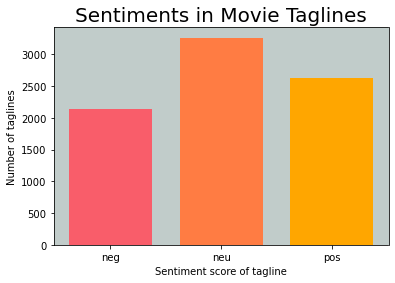

In [135]:
sorted_pd = movie_df['sentiment'].sort_values()
plt.hist(sorted_pd)
ax = plt.axes(facecolor='#C1CCCA')
ax.set_title("Sentiments in Movie Taglines", fontsize=20)
ax.set_xlabel("Sentiment score of tagline")
ax.set_ylabel("Number of taglines")
N, bins, patches = ax.hist(sorted_pd, bins=range(4), align='left', rwidth=.75);

for i in range(0,1):
    patches[i].set_facecolor('#f95d6a')
for i in range(1,2):
    patches[i].set_facecolor('#ff7c43')
for i in range(2,3):
    patches[i].set_facecolor('#ffa600')
plt.xticks(range(3))
plt.show()

<AxesSubplot:title={'center':'Vote Averages per Sentiment'}, xlabel='sentiment', ylabel='vote average'>

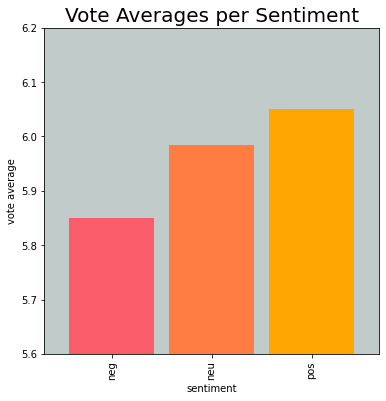

In [77]:
means = movie_df.groupby('sentiment')['vote_average'].mean()
fig, ax = plt.subplots(figsize = (6,6))
ax = plt.axes(facecolor='#C1CCCA')
ax.set_title("Vote Averages per Sentiment", fontsize=20)
plt.grid(color='w', linestyle='solid')
means.plot(kind="bar",ylabel="vote average", width=.85,color=['#f95d6a', '#ff7c43', '#ffa600'], ylim=[5.6,6.2])

Text(0, 0.5, '')

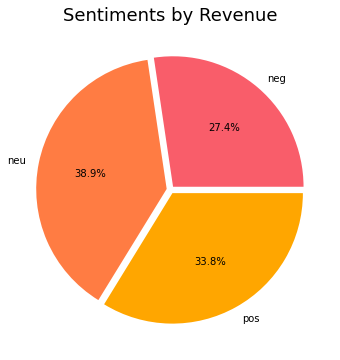

In [129]:
means = movie_df.groupby('sentiment').mean()
fig, ax = plt.subplots(figsize = (6,6))
ax.set_title("Sentiments by Revenue",  fontsize=18)

ax = means.revenue_adj.plot(kind='pie', explode=(0.03, 0.03, 0.03),  colors=['#f95d6a', '#ff7c43', '#ffa600'], autopct='%1.1f%%',  legend=False)
ax.set_ylabel('')

### Preliminary conclusions:  

<div class="alert alert-block alert-info">
Taglines tend to be neutral rather than weighted in one direction or another, but if they must pose a sentiment they skew towards positivity. Revenue returns suggest that this balance of sentiment is also favorable to viewers; neutral scores got the highest returns, while taglines with positive scores were close in second, and negative sentiments in taglines were correlated with slightly worse revenue. For vote averages, on the other hand, positive sentiments in taglines seem to correlate with higher scores while negative sentiments in taglines are still trending with lower scores. 
 </div>

<a id="genre"/></a>
## What effect does the genre have on how the tagline is written?
Now let's group some information by genre to see how categories affect some of the attributes we derived with natural language processing. For this we're going to bring back the mult_genres mask we used when cleaning up genres and just look at sentiment scores instead of putting them into bins

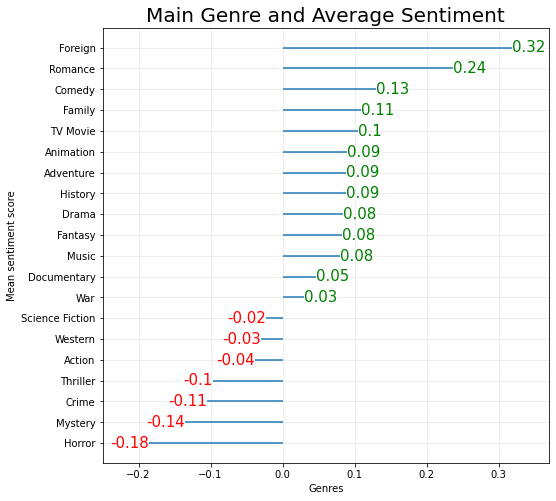

In [72]:
means = movie_df.groupby('main_genres').mean().sentiment_score
genre_sentiment_df = means.to_frame()
genre_sentiment_df.sort_values('sentiment_score', inplace=True)
plt.figure(figsize=(8,8))
plt.hlines(genre_sentiment_df.index, xmin=0, xmax=genre_sentiment_df.sentiment_score)
for x, y, tex in zip(genre_sentiment_df.sentiment_score, genre_sentiment_df.index, genre_sentiment_df.sentiment_score):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':15})
# plt.yticks(genre_sentiment_df.sentiment_score, fontsize=12)
plt.title('Main Genre and Average Sentiment', fontdict={'size':20})
plt.xlabel('Genres')
plt.ylabel('Mean sentiment score')
plt.grid(linestyle='-', alpha=0.25)
plt.xlim(-.25,.37)
plt.show()

<AxesSubplot:title={'center':'Average Sentiment Score Per Genre'}, xlabel='Genre', ylabel='Sentiment score of tagline'>

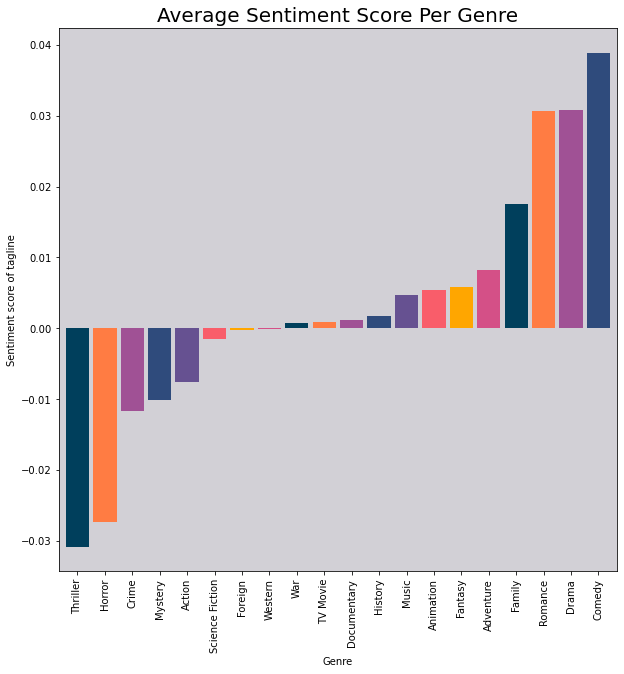

In [140]:
genres_sentiment = mult_genres.multiply(movie_df.sentiment_score, axis="index")
fig, ax = plt.subplots(figsize = (10,10))
ax = plt.axes(facecolor='#d2d0d6')
ax.set_title("Average Sentiment Score Per Genre", fontsize=20)
ax.set_xlabel("Genre")
ax.set_ylabel("Sentiment score of tagline")
series = genres_sentiment.mean()
series.sort_values(ascending=True, axis=0, inplace=True)
series.plot(kind="bar",width=.85, color=['#003f5c','#ff7c43', '#a05195', '#2f4b7c','#665191','#f95d6a', '#ffa600','#d45087'])

#### Preliminary Conclusions:
<div class="alert alert-block alert-info">
In these two graphs, we see that some data looks to be about the same when we account for all genres. Films from genres like thrillers, horror, mysteries and crime consistently use negative sentiments in their taglines, with action and scifi close behind. On the other side, comedies and romance consistently use postive scoring taglines for their movies, but when there is only one genre given it appears that foriegn movies score much higher than when all are accounted for. This leads me to believe there might me a lower sample size of films that have "foreign" as their main category. "Drama" also tends to have much less of a skew towards positive sentiments in taglines, which leads me to believe that maybe there is a higher sample size of films that are not neccessarily listed as "drama" but have it as a subcategorization. 
 </div>

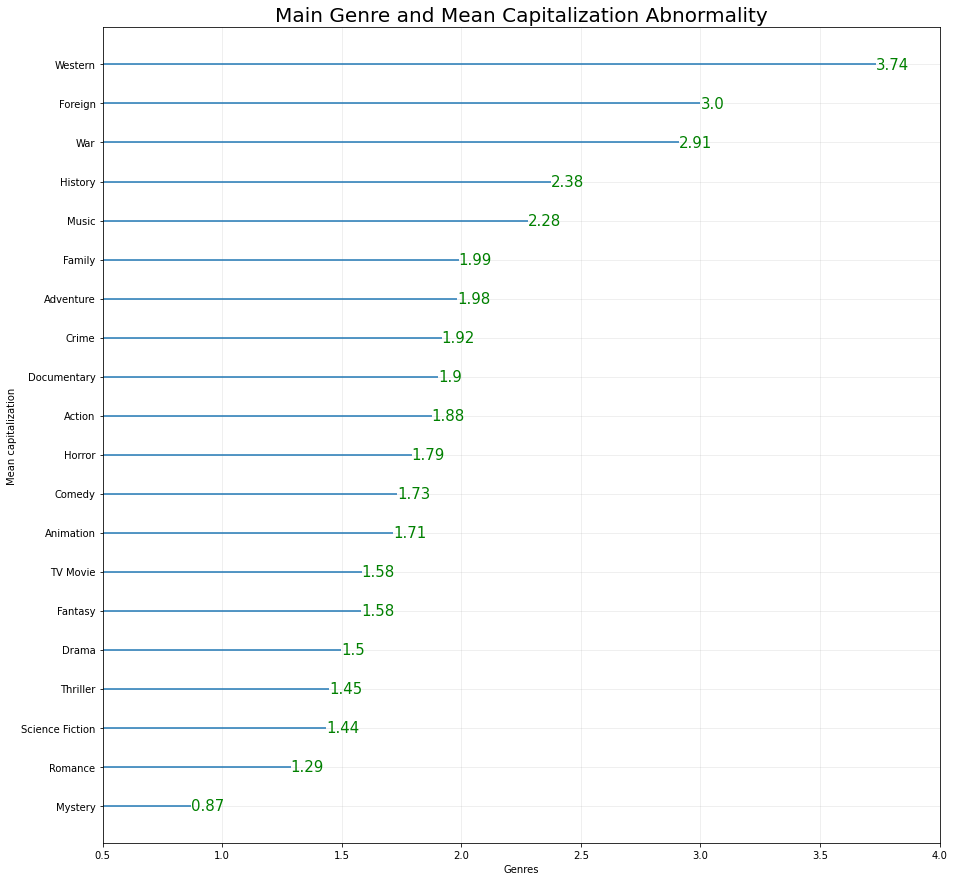

In [73]:
cap_diff = movie_df.groupby('main_genres').mean().cap_diff
genre_cap_diff = cap_diff.to_frame()
genre_cap_diff.sort_values('cap_diff', inplace=True)
plt.figure(figsize=(15,15))
plt.hlines(genre_cap_diff.index, xmin=0, xmax=genre_cap_diff.cap_diff)
for x, y, tex in zip(genre_cap_diff.cap_diff, genre_cap_diff.index, genre_cap_diff.cap_diff):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':15})
plt.title('Main Genre and Mean Capitalization Abnormality', fontdict={'size':20})
plt.grid(linestyle='-', alpha=0.25)
plt.xlabel('Genres')
plt.ylabel('Mean capitalization')
plt.xlim(.5,4)
plt.show()

<AxesSubplot:title={'center':'Difference in Capitalization Scheme For Taglines Per Genre'}, xlabel='Genre', ylabel='Number of capitalized letters outside truecasing'>

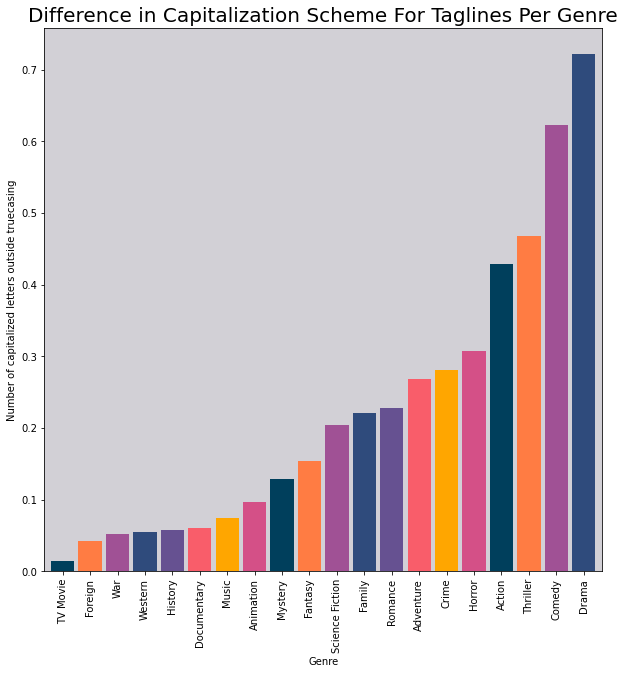

In [141]:
genres_cap_diff = mult_genres.multiply(movie_df.cap_diff, axis="index")
fig, ax = plt.subplots(figsize = (10,10))
ax = plt.axes(facecolor='#d2d0d6')
ax.set_title("Difference in Capitalization Scheme For Taglines Per Genre", fontsize=20)
ax.set_xlabel("Genre")
ax.set_ylabel("Number of capitalized letters outside truecasing")
series = genres_cap_diff.mean()
series.sort_values(ascending=True, axis=0, inplace=True)
series.plot(kind="bar",width=.85, color=['#003f5c','#ff7c43', '#a05195', '#2f4b7c','#665191','#f95d6a',  '#ffa600','#d45087'])


#### Preliminary Conclusions:
<div class="alert alert-block alert-info">
In these two graphs, the disparity is greater. Westerns, foreign films, history films, and war films are all seen as having a high number of casing that does not alighn with truecasing when they are shown as the main category for a film, but when we account for all films that may include these categories as subgenres they are almost exactly the four least likely to have casing that is not aligned with normal grammar rules. In this case, drama, comedies, thrillers, and actions are back at the top. When we are accounting for all films, it seems that all of the categories that had strong sentiments, either strongly or negatively, are the same categories that have abnormal casing in their taglines, with those that have positive sentiments having slightly more abnormal casing than negatively sentimented taglines. 
    </div>

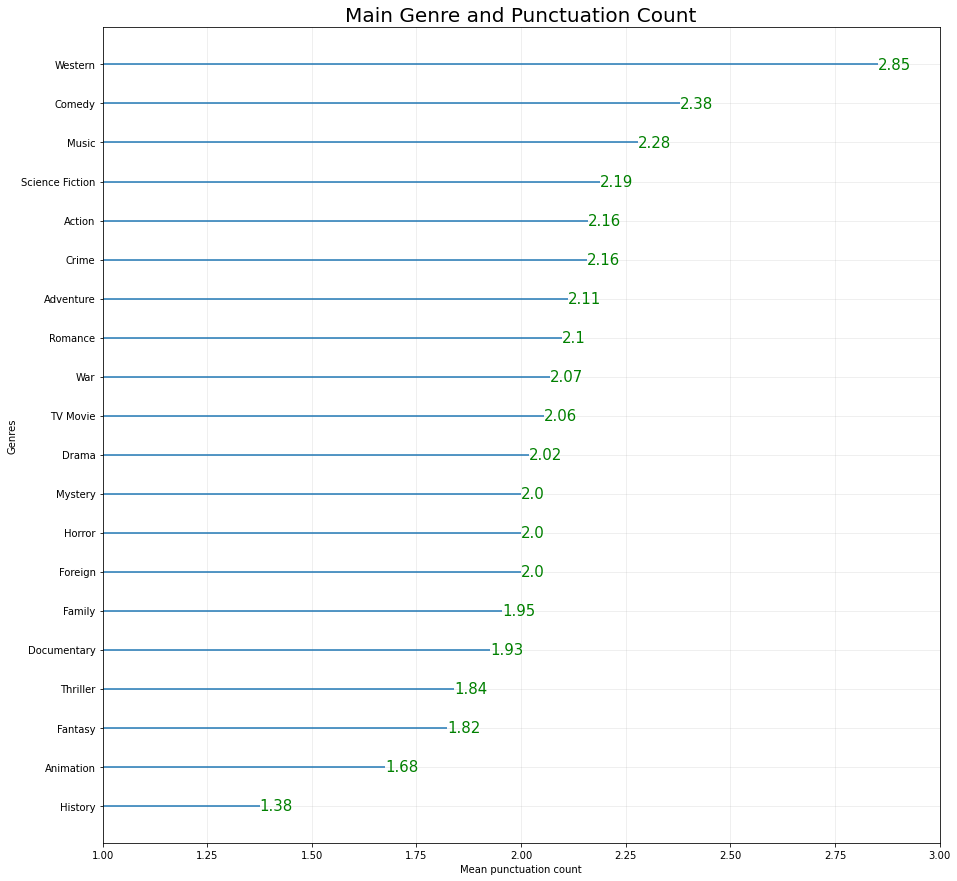

In [71]:
punc_count = movie_df.groupby('main_genres').mean().punc_count
punc_count_df = punc_count.to_frame()
punc_count_df.sort_values('punc_count', inplace=True)
plt.figure(figsize=(15,15))
plt.hlines(punc_count_df.index, xmin=0, xmax=punc_count_df.punc_count)
for x, y, tex in zip(punc_count_df.punc_count, punc_count_df.index, punc_count_df.punc_count):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':15})
# plt.yticks(genre_sentiment_df.sentiment_score, fontsize=12)
plt.title('Main Genre and Punctuation Count', fontdict={'size':20})
plt.xlabel('Mean punctuation count')
plt.ylabel('Genres')
plt.grid(linestyle='-', alpha=0.25)
plt.xlim(1, 3)
plt.show()

<AxesSubplot:title={'center':'Difference in Puncutation For Taglines Per Genre'}, xlabel='Genre', ylabel='Number of Punctuation Marks'>

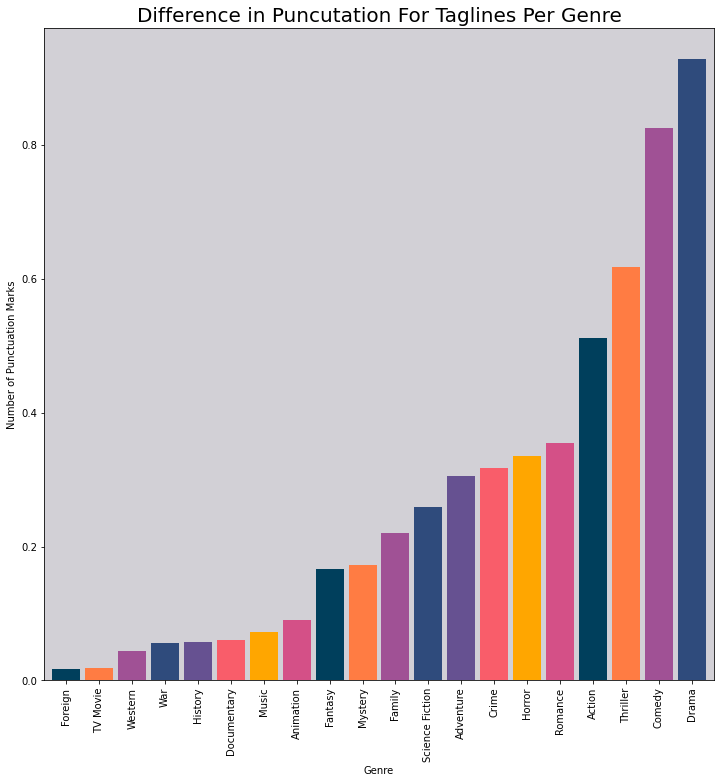

In [142]:
genres_punc_count = mult_genres.multiply(movie_df.punc_count, axis="index")
fig, ax = plt.subplots(figsize = (12,12))
ax = plt.axes(facecolor='#d2d0d6')
ax.set_title("Difference in Puncutation For Taglines Per Genre", fontsize=20)
ax.set_xlabel("Genre")
ax.set_ylabel("Number of Punctuation Marks")
series = genres_punc_count.mean()
series.sort_values(ascending=True, axis=0, inplace=True)
series.plot(kind="bar",width=.85, color=['#003f5c','#ff7c43', '#a05195', '#2f4b7c','#665191','#f95d6a',  '#ffa600','#d45087'])

#### Preliminary Conclusions:
<div class="alert alert-block alert-info">
Comedy and action both seem to have a relatively high number of punctuation marks in both datasets, while history and documentaries tend to have fewer punctuation marks. These two groupings are disparate enough it is difficult to draw definitive conclusions, but overall it looks like dramas and comedies tend to be more emotive in their taglines than most other genres. 
    </div>

<a id='conclusions'></a>
## Conclusions


When we first looked at the correlations of binned sentiment scores with general attributes, I was surprised to see that there is a strong correlation regardless of genre for having a tagline that trends neutral or positive in sentiment. Lower scores in sentiment analysis of taglines was correlated with lower revenue and lower vote averages. It is then not surprising to see that there are fewer taglines that skew negatively than neutral or positively overall. 

I'm very happy that we chose to deal with genres in two different ways, choosing both the first listed as the "main" genre and then also analyzing the genres as if they were each the same weight. The results had large disparities which leads me to think that there is more investigation to be done on how these genres were decided and divided. These graphs were also more interesting because sentiment, casing, and punctuation have clear differences between genres. 

Overall it looks like dramas and comedies tend to be the most emotive in their taglines, as they rank highly in all three metrics, but these are also the broadest categories so it is difficult to see how that affects the scores. In general having stronger sentiment scores correlated positively with heavier usage of punctuation and abnormal casing, but I would be interested in what is going on particularly with foreign films in terms of casing and punctuation-- are these really being used to be emotive? Or are there standards (like having every word capitalized) that we should also be accounting for in our assessment of "truecasing"? 

### Limitations:

The biggest limitation seems to be the disparity in how we are dealing with genres. There needs to more investigation on how these genres are decided and how much weight each should get. Perhaps we also need a bigger dataset with more examples from each genre to smooth out these findings. In later analyses I would also be interested in looking at the year released and finding any trends that may fluctuate over time, particularly with regards to casing and punctuation. I would also be interested in splitting up the dataset further to analyze how the sentiment affected revenue or vote counts per genre, as splitting taglines up into genres showed large fluctuations in these linguistic attributes. 